# Deep Learning Segmentation (pixel wise classification)

First prepare the training dataset.
For all the categories except white matter, we do some spatial smoothing.
For white matter we don't since it's very thin.

['segmentation_masks\\0_0.png', 'segmentation_masks\\0_1.png', 'segmentation_masks\\0_2.png', 'segmentation_masks\\0_3.png', 'segmentation_masks\\0_4.png']


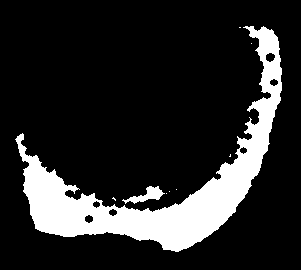

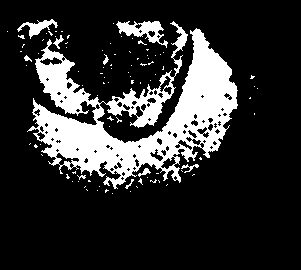

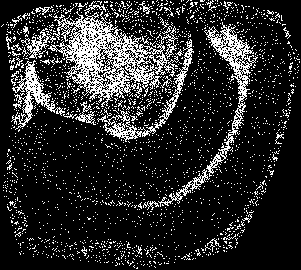

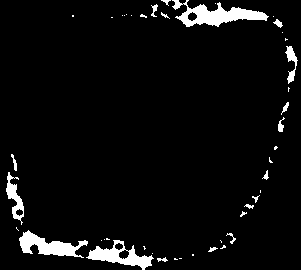

['segmentation_masks\\1_0.png', 'segmentation_masks\\1_1.png', 'segmentation_masks\\1_2.png', 'segmentation_masks\\1_3.png', 'segmentation_masks\\1_4.png']


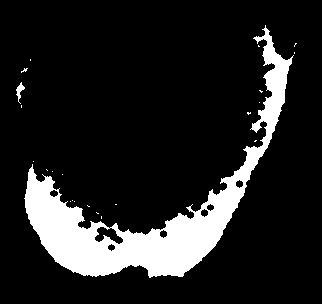

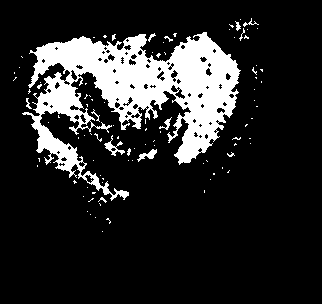

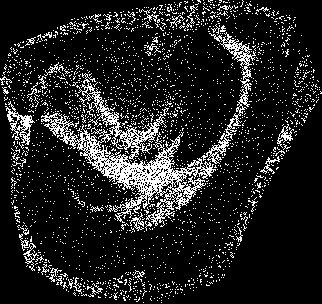

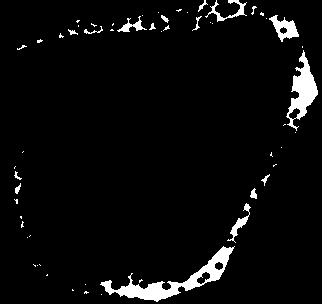

['segmentation_masks\\2_0.png', 'segmentation_masks\\2_1.png', 'segmentation_masks\\2_2.png', 'segmentation_masks\\2_3.png', 'segmentation_masks\\2_4.png']


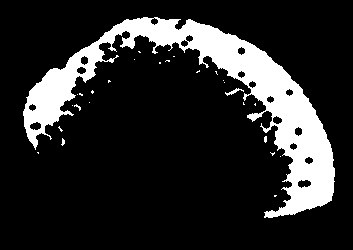

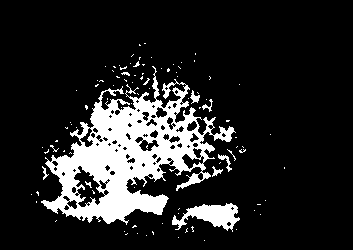

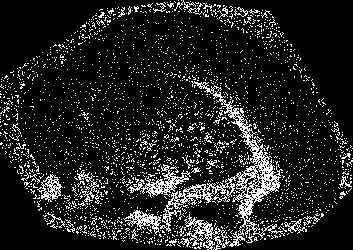

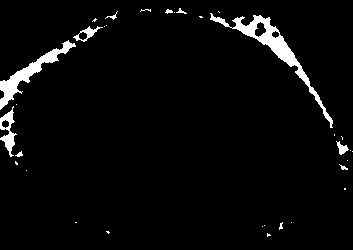

['segmentation_masks\\3_0.png', 'segmentation_masks\\3_1.png', 'segmentation_masks\\3_2.png', 'segmentation_masks\\3_3.png', 'segmentation_masks\\3_4.png']


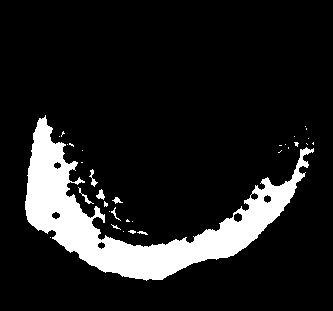

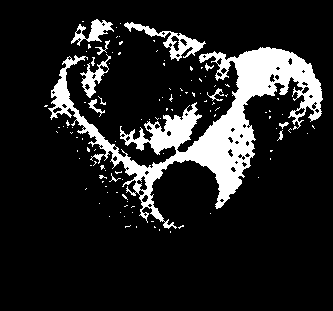

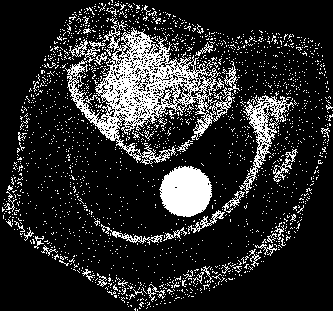

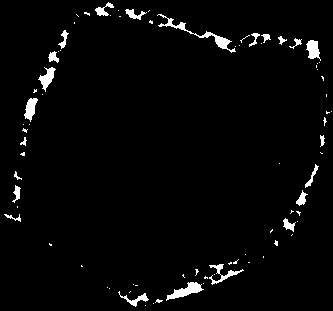

(180765, 5005) (180765,)


In [1]:
import numpy as np
import cv2
import torch
from PIL import Image
import glob
from pathlib import Path
import segmentation
import importlib
importlib.reload(segmentation)
import segmentation
from segmentation import preprocess

image_paths = glob.glob(r"D:\\maldi\\tol_None_5_bins\\*.npy")

train_data = []
labels = []
for p in image_paths:
    region = Path(p).stem
    mask_paths = sorted(glob.glob(f"segmentation_masks//{region}_*.png"))
    print(mask_paths)
    img = np.load(p)
    img = preprocess(img)
        
    for i in range(4):
        mask = np.array(Image.open(mask_paths[i]))

        if i != 2:
            mask = cv2.medianBlur(mask, 3)
            if i == 1:
                dilatation_size = 1
            else:
                dilatation_size = 3
            element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * dilatation_size + 1, 2 * dilatation_size + 1),
                                            (dilatation_size, dilatation_size))
            mask = cv2.erode(mask, element)


        display(Image.fromarray(mask))

        data = img[mask > 0].reshape(-1, img.shape[-1])
        labels.extend([i] * len(data))
        train_data.append(data)

train_data = np.concatenate(train_data, axis=0)
labels = np.float32(labels)
print(train_data.shape, labels.shape)

# Train a deep neural network N on N(mz * weight) where weight is an L1 regularized learned weights, so we end up using just some of the m/z's.

In [2]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
import tqdm
from visualizations import visualizations_from_explanations
import segmentation
import importlib
importlib.reload(segmentation)
import segmentation
from segmentation import SegmentationDataset, SegmentationModel


model = SegmentationModel()
model.cuda()
optim = AdamW(model.parameters())
weight = torch.Tensor([1, 15, 2, 1]).cuda()
criterion = torch.nn.CrossEntropyLoss(reduction='mean', weight=weight, label_smoothing=0.2)
dataset = SegmentationDataset(train_data, labels)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)
optim.zero_grad()
for epoch in tqdm.tqdm(range(50)):
    epoch_loss = []
    for batch_data, batch_labels in dataloader:
        batch_data = batch_data.cuda()
        batch_labels = batch_labels.cuda()
        batch_labels = batch_labels.long()
        batch_predictions = model(batch_data)
        loss = criterion(batch_predictions, batch_labels) + 0.01 * torch.abs(model.weights).sum()
        loss.backward()
        optim.step()
        epoch_loss.append(loss.detach().item())
        optim.zero_grad()
    print(epoch, np.mean(epoch_loss), model.weights.mean(), model.weights.max())
torch.save(model.state_dict(), "models/segmentation.pth")

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=5005, out_features=256, bias=True)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.2, inplace=False)
  (5): Linear(in_features=256, out_features=128, bias=True)
  (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=64, out_features=4, bias=True)
)


  2%|▏         | 1/50 [00:05<04:11,  5.13s/it]

0 46.023009542691504 tensor(0.8214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.8219, device='cuda:0', grad_fn=<MaxBackward1>)


  4%|▍         | 2/50 [00:08<03:26,  4.30s/it]

1 37.03886234692934 tensor(0.6431, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.6446, device='cuda:0', grad_fn=<MaxBackward1>)


  6%|▌         | 3/50 [00:12<03:06,  3.97s/it]

2 28.116224116524734 tensor(0.4651, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.4686, device='cuda:0', grad_fn=<MaxBackward1>)


  8%|▊         | 4/50 [00:15<02:55,  3.81s/it]

3 19.212284734693625 tensor(0.2875, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.2938, device='cuda:0', grad_fn=<MaxBackward1>)


 10%|█         | 5/50 [00:19<02:46,  3.70s/it]

4 10.325033718583274 tensor(0.1101, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.1237, device='cuda:0', grad_fn=<MaxBackward1>)


 12%|█▏        | 6/50 [00:23<02:43,  3.71s/it]

5 2.1141572875828394 tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0147, device='cuda:0', grad_fn=<MaxBackward1>)


 14%|█▍        | 7/50 [00:26<02:39,  3.70s/it]

6 0.4095688443736168 tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0294, device='cuda:0', grad_fn=<MaxBackward1>)


 16%|█▌        | 8/50 [00:30<02:33,  3.66s/it]

7 0.4032036588016876 tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0307, device='cuda:0', grad_fn=<MaxBackward1>)


 18%|█▊        | 9/50 [00:34<02:30,  3.68s/it]

8 0.3997018488786988 tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0297, device='cuda:0', grad_fn=<MaxBackward1>)


 20%|██        | 10/50 [00:37<02:27,  3.69s/it]

9 0.3970865024685186 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0287, device='cuda:0', grad_fn=<MaxBackward1>)


 22%|██▏       | 11/50 [00:41<02:24,  3.71s/it]

10 0.395319700746213 tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0273, device='cuda:0', grad_fn=<MaxBackward1>)


 24%|██▍       | 12/50 [00:45<02:20,  3.70s/it]

11 0.3944499154212111 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0324, device='cuda:0', grad_fn=<MaxBackward1>)


 26%|██▌       | 13/50 [00:49<02:17,  3.72s/it]

12 0.3930802756110154 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0315, device='cuda:0', grad_fn=<MaxBackward1>)


 28%|██▊       | 14/50 [00:52<02:11,  3.66s/it]

13 0.39171692526946633 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0313, device='cuda:0', grad_fn=<MaxBackward1>)


 30%|███       | 15/50 [00:56<02:08,  3.67s/it]

14 0.39084448130790794 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0310, device='cuda:0', grad_fn=<MaxBackward1>)


 32%|███▏      | 16/50 [01:00<02:04,  3.67s/it]

15 0.3899565953656105 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0293, device='cuda:0', grad_fn=<MaxBackward1>)


 34%|███▍      | 17/50 [01:03<02:03,  3.73s/it]

16 0.3892097011797846 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0314, device='cuda:0', grad_fn=<MaxBackward1>)


 36%|███▌      | 18/50 [01:07<02:01,  3.79s/it]

17 0.389311642970069 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0307, device='cuda:0', grad_fn=<MaxBackward1>)


 38%|███▊      | 19/50 [01:11<02:00,  3.90s/it]

18 0.3890405842813395 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0298, device='cuda:0', grad_fn=<MaxBackward1>)


 40%|████      | 20/50 [01:16<01:59,  4.00s/it]

19 0.3892346964044086 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0306, device='cuda:0', grad_fn=<MaxBackward1>)


 42%|████▏     | 21/50 [01:20<01:59,  4.11s/it]

20 0.3889011048664481 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0327, device='cuda:0', grad_fn=<MaxBackward1>)


 44%|████▍     | 22/50 [01:24<01:56,  4.16s/it]

21 0.38884612362263565 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0313, device='cuda:0', grad_fn=<MaxBackward1>)


 46%|████▌     | 23/50 [01:29<01:54,  4.26s/it]

22 0.38864649790155015 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0316, device='cuda:0', grad_fn=<MaxBackward1>)


 48%|████▊     | 24/50 [01:33<01:51,  4.30s/it]

23 0.38905128853469245 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0319, device='cuda:0', grad_fn=<MaxBackward1>)


 50%|█████     | 25/50 [01:38<01:48,  4.34s/it]

24 0.3890269442466693 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0295, device='cuda:0', grad_fn=<MaxBackward1>)


 52%|█████▏    | 26/50 [01:42<01:42,  4.26s/it]

25 0.3884519077626999 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0297, device='cuda:0', grad_fn=<MaxBackward1>)


 54%|█████▍    | 27/50 [01:47<01:42,  4.45s/it]

26 0.3882252523454569 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0324, device='cuda:0', grad_fn=<MaxBackward1>)


 56%|█████▌    | 28/50 [01:51<01:35,  4.33s/it]

27 0.3884735765766963 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0303, device='cuda:0', grad_fn=<MaxBackward1>)


 58%|█████▊    | 29/50 [01:55<01:29,  4.28s/it]

28 0.38896053642202905 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0310, device='cuda:0', grad_fn=<MaxBackward1>)


 60%|██████    | 30/50 [01:59<01:25,  4.27s/it]

29 0.38938744846036877 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0328, device='cuda:0', grad_fn=<MaxBackward1>)


 62%|██████▏   | 31/50 [02:03<01:20,  4.24s/it]

30 0.3895582534835837 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0311, device='cuda:0', grad_fn=<MaxBackward1>)


 64%|██████▍   | 32/50 [02:07<01:14,  4.17s/it]

31 0.3888700069007227 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0322, device='cuda:0', grad_fn=<MaxBackward1>)


 66%|██████▌   | 33/50 [02:12<01:11,  4.22s/it]

32 0.38931691444526284 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0309, device='cuda:0', grad_fn=<MaxBackward1>)


 68%|██████▊   | 34/50 [02:16<01:07,  4.20s/it]

33 0.3889580389200631 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0316, device='cuda:0', grad_fn=<MaxBackward1>)


 70%|███████   | 35/50 [02:20<01:03,  4.24s/it]

34 0.38889475124703965 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0322, device='cuda:0', grad_fn=<MaxBackward1>)


 72%|███████▏  | 36/50 [02:24<00:58,  4.21s/it]

35 0.3888716034296542 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0316, device='cuda:0', grad_fn=<MaxBackward1>)


 74%|███████▍  | 37/50 [02:28<00:54,  4.20s/it]

36 0.3893635963316018 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0322, device='cuda:0', grad_fn=<MaxBackward1>)


 76%|███████▌  | 38/50 [02:33<00:50,  4.19s/it]

37 0.3883572254477248 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0325, device='cuda:0', grad_fn=<MaxBackward1>)


 78%|███████▊  | 39/50 [02:37<00:46,  4.24s/it]

38 0.3894015293000108 tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0333, device='cuda:0', grad_fn=<MaxBackward1>)


 80%|████████  | 40/50 [02:41<00:42,  4.21s/it]

39 0.38905434520904625 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0337, device='cuda:0', grad_fn=<MaxBackward1>)


 82%|████████▏ | 41/50 [02:45<00:37,  4.21s/it]

40 0.38918039135340243 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0311, device='cuda:0', grad_fn=<MaxBackward1>)


 84%|████████▍ | 42/50 [02:49<00:33,  4.19s/it]

41 0.38921285365934427 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0345, device='cuda:0', grad_fn=<MaxBackward1>)


 86%|████████▌ | 43/50 [02:54<00:29,  4.17s/it]

42 0.3883079148955264 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0310, device='cuda:0', grad_fn=<MaxBackward1>)


 88%|████████▊ | 44/50 [02:58<00:24,  4.13s/it]

43 0.38852760162057176 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0300, device='cuda:0', grad_fn=<MaxBackward1>)


 90%|█████████ | 45/50 [03:02<00:21,  4.21s/it]

44 0.38864346463127997 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0337, device='cuda:0', grad_fn=<MaxBackward1>)


 92%|█████████▏| 46/50 [03:06<00:16,  4.17s/it]

45 0.38853271667566674 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0330, device='cuda:0', grad_fn=<MaxBackward1>)


 94%|█████████▍| 47/50 [03:10<00:12,  4.14s/it]

46 0.3889161200173157 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0305, device='cuda:0', grad_fn=<MaxBackward1>)


 96%|█████████▌| 48/50 [03:14<00:08,  4.06s/it]

47 0.3887820521653709 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0314, device='cuda:0', grad_fn=<MaxBackward1>)


 98%|█████████▊| 49/50 [03:18<00:04,  4.14s/it]

48 0.389161318035449 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0321, device='cuda:0', grad_fn=<MaxBackward1>)


100%|██████████| 50/50 [03:22<00:00,  4.06s/it]

49 0.38841282277457456 tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.0324, device='cuda:0', grad_fn=<MaxBackward1>)


# Deploy on slide 2 and visualize the results after learning on slide 4.

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=5005, out_features=256, bias=True)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.2, inplace=False)
  (5): Linear(in_features=256, out_features=128, bias=True)
  (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=64, out_features=4, bias=True)
)
model loaded
(4, 262, 286)


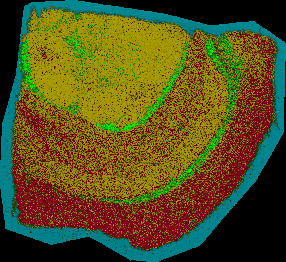

(4, 248, 331)


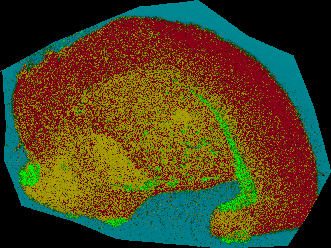

(4, 292, 314)


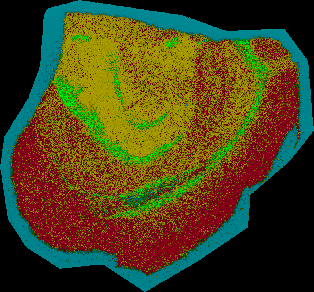

(4, 285, 314)


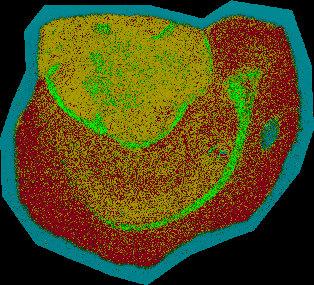

In [2]:
import segmentation
import importlib
importlib.reload(segmentation)
import segmentation
import torch
from segmentation import get_visualization, DeepLearningSegmentation

import glob
from pathlib import Path
import numpy as np
from PIL import Image

paths = glob.glob("D:\maldi\slides\slide2_notol_5_bin\\*.npy")
#paths = glob.glob("D:\\maldi\\tol_None_5_bins\\*.npy")
seg = DeepLearningSegmentation()

for p in paths:
    img = np.load(p)[:, :, :5005]
    output = seg(img)
    print(output.shape)
    output = torch.nn.Softmax(dim=0)(torch.from_numpy(output)).numpy()

    # indices = []
    # np.percentile(output, 70)
    output[1, :, :] -= 0.4
    output[2, :, :] += 0.2

    _, visualization = get_visualization(img, output)
    visualization[img.max(axis=-1) == 0] = 0
    display(Image.fromarray(visualization))

# Check 10 the top m/z's used.

In [3]:
mzs = seg.model.weights.abs().detach().cpu().numpy().argsort()[-10 : ]
print(300 + mzs/5)

[309.  315.  407.  331.  308.2 310.8 330.  309.2 391.  361. ]
